<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/unet_RGB_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/"

## Installing packages

In [3]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2
from skimage import color

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from sklearn.model_selection import train_test_split

## Defining functions

In [11]:
def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]
    crop_top = int((height - height / zoom_factor) / 2)# Calculate the region to crop around the center
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]    # Crop the image
    resized_image = cv2.resize(cropped_image, (width, height))# Resize the zoomed image back to the original dimensions
    return resized_image

def crop(im):
    width, height = im.size
    data = []
    step = int(size * 0.80)  # Adjust the step size for cropping
    for j in range(0, height, step):
        for i in range(0, width, step):
            if i + size <= width and j + size <= height:
                im1 = im.crop((i, j, i + size, j + size))
                im1 = np.array(im1).astype(np.float32)
                data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                for z in zoom_factor:
                    zoomed_img = zoom_and_resize(im1, z)
                    data.append(zoomed_img/255)
    return data

def contrast_stretch(image):
    img_array = np.array(image)
    for i in range(3):  # 3 channels: Red, Green, Blue
        # Compute min and max pixel intensity values for the channel
        min_val = np.min(img_array[:,:,i])
        max_val = np.max(img_array[:,:,i])
        # Apply contrast stretching
        img_array[:,:,i] = (img_array[:,:,i] - min_val) * (255.0 / (max_val - min_val))
    # Convert numpy array back to PIL Image
    stretched_image = Image.fromarray(np.uint8(img_array))
    return stretched_image

## Preparing the training dataset

In [12]:
size = 16
model_number = size

zoom_factor = [1.5,2.0]
input = []
output = []

input_folder_path = file_path + 'Training/input/'
output_folder_path = file_path + 'Training/output/'

# List all files in the directory and sort them alphabetically
input_files = sorted(os.listdir(input_folder_path))
output_files = sorted(os.listdir(output_folder_path))


for image_file in input_files:
    image_path = os.path.join(input_folder_path, image_file)
    image = contrast_stretch(Image.open(image_path).convert('RGB'))
    image = crop(image)
    input.extend(image)

for image_file in output_files:
    image_path = os.path.join(output_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = crop(image)
    output.extend(image)
input = np.array(input)
output = np.array(output)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

input = []
output = []

Done reading the input of size =  (109971, 16, 16, 3)
Done reading the output of size =  (109971, 16, 16, 3)
Done reading the train input of size =  (87976, 16, 16, 3)
Done reading the test input of size =  (21995, 16, 16, 3)
Done reading the train output of size =  (87976, 16, 16, 3)
Done reading the test output of size =  (21995, 16, 16, 3)


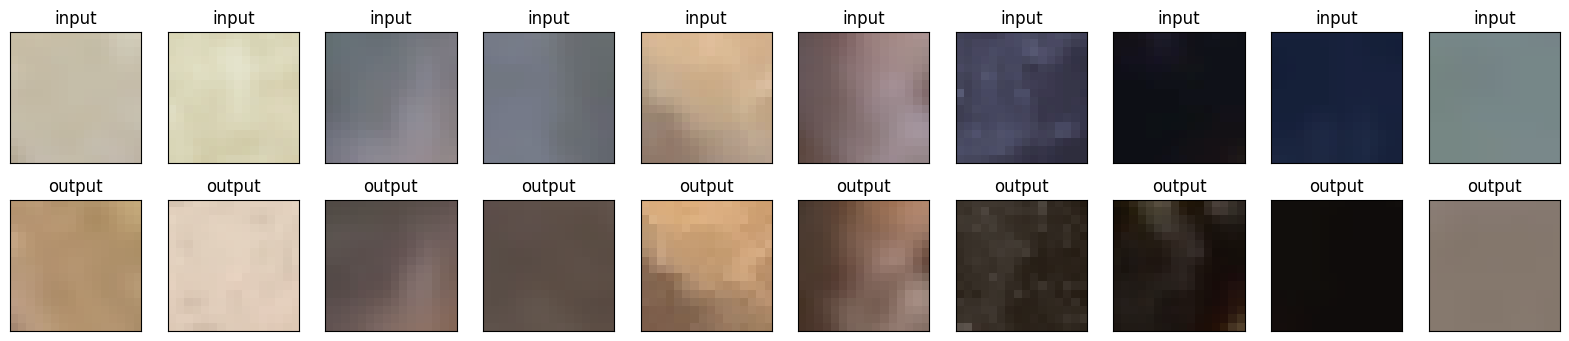

In [15]:
N = 10000
n = 10
plt.figure(figsize=(20, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Creating the Unet model

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def unet_model(input_shape=(size, size, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', strides=2)(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)

    #conv3 = Conv2D(32, 3, activation='relu', padding='same', strides=2)(conv2)
    #conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)

    #conv4 = Conv2D(64, 3, activation='relu', padding='same', strides=2)(conv3)
    #conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    #conv5 = concatenate([Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv4), conv3], axis=-1)
    #conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    #conv6 = concatenate([Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv3), conv2], axis=-1)
    #conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)

    conv7 = concatenate([Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv2), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 16, 16, 32)           896       ['input_3[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 16, 16, 32)           9248      ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 16, 16, 32)           9248      ['conv2d_19[0][0]']           
                                                                                            

## Training the Unet model

In [19]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt, loss=ssim_loss)  # Using SSIM loss function
#unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
# Train your model as before
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=250,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/unet_' + str(model_number) + '_rgb')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'Model/loss_'+ str(model_number) + '_rgb.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'Model/val_loss_'+ str(model_number)+ '_rgb.csv')

Epoch 1/250
2750/2750 [==============================] - 31s 9ms/step - loss: 0.1225 - val_loss: 0.1231
Epoch 2/250
2750/2750 [==============================] - 23s 8ms/step - loss: 0.1211 - val_loss: 0.1217
Epoch 3/250
2750/2750 [==============================] - 25s 9ms/step - loss: 0.1200 - val_loss: 0.1200
Epoch 4/250
2750/2750 [==============================] - 24s 9ms/step - loss: 0.1190 - val_loss: 0.1197
Epoch 5/250
2750/2750 [==============================] - 25s 9ms/step - loss: 0.1183 - val_loss: 0.1194
Epoch 6/250
2750/2750 [==============================] - 24s 9ms/step - loss: 0.1173 - val_loss: 0.1186
Epoch 7/250
2750/2750 [==============================] - 26s 9ms/step - loss: 0.1165 - val_loss: 0.1180
Epoch 8/250
2750/2750 [==============================] - 22s 8ms/step - loss: 0.1159 - val_loss: 0.1168
Epoch 9/250
2750/2750 [==============================] - 24s 9ms/step - loss: 0.1154 - val_loss: 0.1163
Epoch 10/250
2750/2750 [==============================] - 25s 9m

## Testing the model

In [ ]:
n_size = 16
size = 16

def rgb_L_ab(rgb_image, test_L):
    lab_array = color.rgb2lab(np.array(rgb_image))# Convert RGB to LAB colorspace
    lab_array[..., 0] = test_L #Change L channel to input
    rgb_array = color.lab2rgb(lab_array)# Convert back LAB to RGB colorspace
    rgb_array = (rgb_array * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_array = Image.fromarray(rgb_array, mode='RGB')# Convert RGB array back to image
    return rgb_array

def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data

#----------------READING THE TEST IMAGE--------------------#
filename = str("[15]Come Hither-Before.png")
test = contrast_stretch(Image.open(file_path+ "Testing/" + filename).convert('RGB'))
test_L = color.rgb2lab(np.array(test))
test_L = test_L[..., 0]
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

autoencoder = keras.models.load_model(file_path + 'Model/unet_'+str(n_size)+'_rgb', custom_objects={'ssim_loss': ssim_loss})

xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

#----------------TEST ON FULL RGB--------------------#
final_rgb = final
final_rgb = np.squeeze(final_rgb)
reconstructed_rgb = Image.fromarray(final_rgb)
reconstructed_rgb.save(file_path + "Testing/"+"Model_1_"+filename)
plt.figure(), plt.imshow(reconstructed_rgb)

#----------------TEST ON L from input and AB from convert RGB2LAB of model--------------------#
final_lab = rgb_L_ab(final, test_L)
final_lab = np.squeeze(final_lab)
reconstructed_lab = Image.fromarray(final_lab)
reconstructed_lab.save(file_path + "Testing/"+"Model_2_"+filename)
plt.figure(), plt.imshow(reconstructed_lab)

In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to open image and convert to numpy array
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    return np.array(image)

image_path1 = file_path + 'Testing/[15]Come Hither-After.png'
image_path2 = file_path + "Testing/"+"Model_2_"+filename

# Load images
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Ensure the images have the same dimensions
if image1.shape != image2.shape:
    raise ValueError("Input images must have the same dimensions.")

# Compute SSIM for each channel and average the results
ssim_index_r = ssim(image1[:, :, 0], image2[:, :, 0], data_range=image1[:, :, 0].max() - image1[:, :, 0].min())
ssim_index_g = ssim(image1[:, :, 1], image2[:, :, 1], data_range=image1[:, :, 1].max() - image1[:, :, 1].min())
ssim_index_b = ssim(image1[:, :, 2], image2[:, :, 2], data_range=image1[:, :, 2].max() - image1[:, :, 2].min())

ssim_index_rgb = (ssim_index_r + ssim_index_g + ssim_index_b) / 3

print(f"SSIM for R channel: {ssim_index_r}")
print(f"SSIM for G channel: {ssim_index_g}")
print(f"SSIM for B channel: {ssim_index_b}")
print(f"Average SSIM for RGB image(Method4): {ssim_index_rgb}")

SSIM for R channel: 0.7135495848132634
SSIM for G channel: 0.7148738323294628
SSIM for B channel: 0.6639641471293708
Average SSIM for RGB image(Method4): 0.6974625214240323
